In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np

In [2]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [3]:
import torch
import math

def distance_point_to_line(px, py, x1, y1, x2, y2):
    """Calculate the perpendicular distance from point (px, py) to the line segment (x1, y1) -> (x2, y2)."""
    line_length_sq = (x2 - x1) ** 2 + (y2 - y1) ** 2
    if line_length_sq == 0:  # The segment is a point
        return math.sqrt((px - x1) ** 2 + (py - y1) ** 2)

    t = max(0, min(1, ((px - x1) * (x2 - x1) + (py - y1) * (y2 - y1)) / line_length_sq))
    proj_x = x1 + t * (x2 - x1)
    proj_y = y1 + t * (y2 - y1)
    return math.sqrt((px - proj_x) ** 2 + (py - proj_y) ** 2)

def calculate_star_vertices(R, r, n=5):
    """Calculate the vertices of a regular star with n points centered at the origin."""
    vertices = []
    angle_between_points = 2 * math.pi / (2 * n)
    for i in range(2 * n):
        if i % 2 == 0:
            radius = R  # Outer point
        else:
            radius = r  # Inner point
        angle = i * angle_between_points
        x = radius * math.cos(angle)
        y = radius * math.sin(angle)
        vertices.append((x, y))
    return vertices

def is_point_inside_star(x, y, star_vertices):
    """
    Determines if a point is inside the star by using the ray-casting method.
    :param x: x-coordinate of the point
    :param y: y-coordinate of the point
    :param star_vertices: List of vertices of the star
    :return: True if the point is inside the star, False otherwise
    """
    num_vertices = len(star_vertices)
    inside = False
    for i in range(num_vertices):
        x1, y1 = star_vertices[i]
        x2, y2 = star_vertices[(i + 1) % num_vertices]
        
        # Check if point (x, y) is inside the star by ray-casting
        if ((y1 > y) != (y2 > y)) and (x < (x2 - x1) * (y - y1) / (y2 - y1) + x1):
            inside = not inside
    return inside

def distance_from_star_contour(coord, R=1, r=0.5, n=5):
    """Calculate the signed distance from point (x, y) to the contour of a star shape.
    Positive if the point is inside the star, negative if the point is outside."""
    x=coord[0]
    y=coord[1]
    # Get star vertices
    vertices = calculate_star_vertices(R, r, n)
    
    # Calculate the minimum distance from point to the star contour
    min_distance = float('inf')
    for i in range(len(vertices)):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % len(vertices)]
        dist = distance_point_to_line(x, y, x1, y1, x2, y2)
        min_distance = min(min_distance, dist)
    
    # Determine if point is inside or outside the star
    inside = is_point_inside_star(x, y, vertices)
    
    # Return positive distance if inside, negative if outside
    return min_distance if inside else -min_distance



In [4]:
def generate_data(num_samples,fun_num = 0):
    if fun_num == 0: # circle
        # Generate random (x, y) coordinates between -1 and 1
        x = torch.rand(num_samples, 2) * 2 - 1  # Range [-1, 1]
        # Compute the target function: 1 - x^2 - y^2
        y = 1 - x[:, 0] ** 2 - x[:, 1] ** 2
        return x, y.view(-1, 1)
    elif fun_num==1: #star shape
        coordinates = 2 * torch.rand(num_samples, 2) - 1  # Tensor of shape (500, 2) with values in range [-1, 1]

        # Calculate distances for each point
        distances = torch.empty(num_samples,1)
        for i in range(num_samples):
            x, y = coordinates[i]
            distances[i] = distance_from_star_contour([x.item(), y.item()])
        
        return coordinates, distances
    else:
        raise NotImplementedError
    

In [26]:
import matplotlib.pyplot as plt 
def plotDisctancefunction(eval_fun, N=500):
    x_values = np.linspace(-1, 1, N)
    y_values = np.linspace(-1, 1, N)
    X, Y = np.meshgrid(x_values, y_values)
    Z = np.zeros((N,N))
    # Evaluate the function at each point in the grid
    for idxx, xx in enumerate(x_values):
        for idxy,yy in enumerate(y_values):
            #print(yy)
            try:
                crd = torch.tensor([xx, yy], dtype=torch.float32)
                ans = eval_fun(crd)
                Z[idxx, idxy] = ans[0].item()
            except:
                Z[idxx, idxy] = eval_fun([xx,yy])

    #Z = distanceFromContur(X, Y)

    # Create a contour plot
    plt.contour(X, Y, Z,levels=20)
    #plt.colorbar(label='f(x, y)')
    highlight_level = 0.0
    plt.contour(X, Y, Z, levels=[highlight_level], colors='red')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Scalar-Valued Function f(x, y)')
    plt.grid(True)
    plt.show()

In [29]:
img_siren = Siren(in_features=2, out_features=1, hidden_features=256,hidden_layers=2, outermost_linear=True)
total_steps = 50 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = total_steps/10

optim = torch.optim.Adam(lr=1e-3, params=img_siren.parameters())
#optim = torch.optim.SGD(img_siren.parameters(), lr=0.0001, momentum=0.9)
#optim = torch.optim.RMSprop(img_siren.parameters(), lr=0.001, alpha=0.99, eps=1e-08)
#optim = torch.optim.Adagrad(img_siren.parameters(), lr=0.01)
#optim = torch.optim.Adadelta(img_siren.parameters(), lr=1.0, rho=0.9, eps=1e-06)





#model_input, ground_truth = generate_data(40000,0)

In [34]:
total_steps = 10
steps_til_summary = total_steps/10
for step in range(total_steps):
    model_input, ground_truth = generate_data(5000,1)
    #print(ground_truth)
    model_output,_ = img_siren(model_input)
    #print(model_output)
    loss = ((model_output - ground_truth)**2).mean()
    #loss = mse + l0_regularization(img_siren,1e-8)


    if not step % steps_til_summary:
        print("Step %d, Total loss %0.8f" % (step, loss))
        #plotDisctancefunction(relu_model,N=20)

    optim.zero_grad()
    loss.backward()
    optim.step()
print("Step %d, Total loss %0.8f" % (step, loss))

Step 0, Total loss 0.00000723
Step 1, Total loss 0.00000661
Step 2, Total loss 0.00000556
Step 3, Total loss 0.00000541
Step 4, Total loss 0.00000612
Step 5, Total loss 0.00000680
Step 6, Total loss 0.00000662
Step 7, Total loss 0.00000585
Step 8, Total loss 0.00000599
Step 9, Total loss 0.00000542
Step 9, Total loss 0.00000542


In [21]:
model_input, ground_truth = generate_data(3,1)
crd,model_output = img_siren(model_input)
tmp = model_output - ground_truth
tmp2 = tmp**2
loss0 = tmp2.mean()
loss = ((model_output - ground_truth)**2).mean()

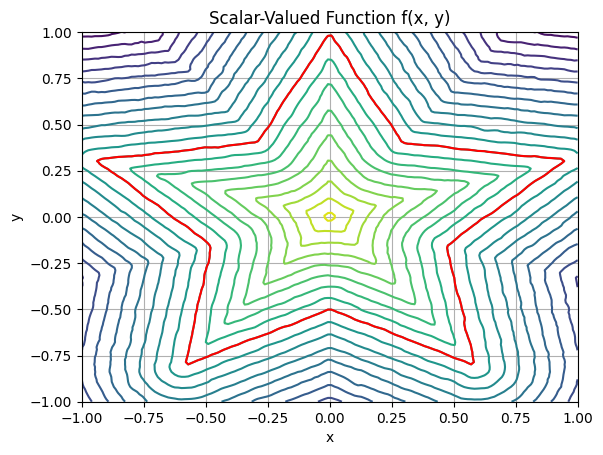

In [35]:
plotDisctancefunction(img_siren,N=150)

In [36]:
torch.save(img_siren.state_dict(), "siren_model_last.pth")
print("Model saved successfully")

Model saved successfully


In [84]:
# Test the trained model on some new data
test_coords = torch.tensor([0, 1], dtype=torch.float32)
predictions = img_siren(test_coords)
#model.test()
print("\nTest Input (x, y):")
print(test_coords)
print("Predicted Output:")
print(predictions)
print("Actual output:")
print(1-test_coords[0] ** 2 - test_coords[1] ** 2 )


Test Input (x, y):
tensor([0., 1.])
Predicted Output:
(tensor([-0.0032], grad_fn=<ViewBackward0>), tensor([0., 1.], requires_grad=True))
Actual output:
tensor(0.)


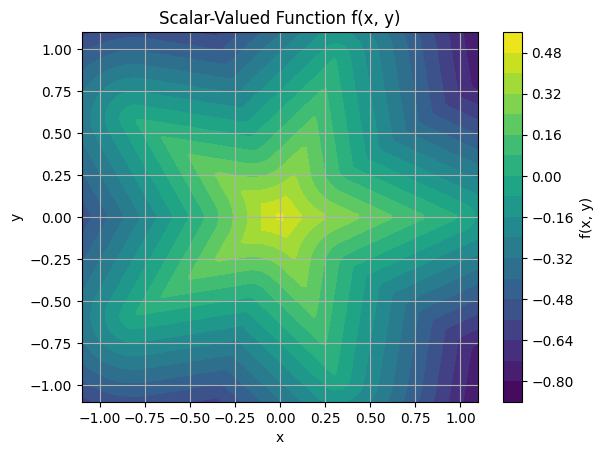

In [21]:
plotDisctancefunction(distance_from_star_contour,N=100)